In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, ), (0.5, ))
])
dataset = torchvision.datasets.MNIST('../data/mnist', train=True, transform=transform, download=False)

dataset[0][0].min(), dataset[0][0].max()

(tensor(0.), tensor(1.))

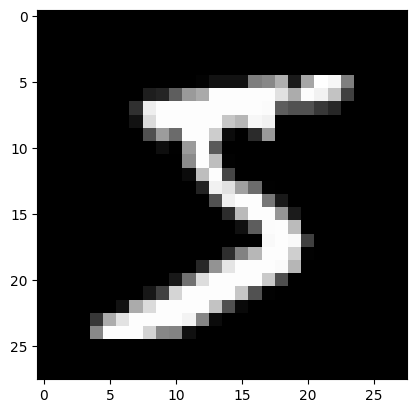

In [3]:
plt.imshow(dataset[0][0].permute(1, 2, 0), cmap='gray');

In [4]:
def show_images(images, nrow=8, title=None):
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0))
    if title is not None:
        plt.title(title)
    plt.show()

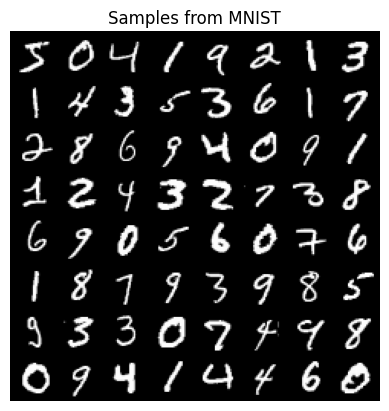

In [5]:
show_images(torch.stack([dataset[i][0] for i in range(64)]), title='Samples from MNIST');

In [6]:
class Encoder(nn.Module):
    def __init__(self, img_channels, hidden_dim, z_dim):
        super().__init__()

        self.z_dim = z_dim
        
        self.net = nn.Sequential( # 28x28
            self.__basic_block(img_channels, hidden_dim, kernel_size=4, stride=2), # 13x13
            self.__basic_block(hidden_dim, hidden_dim*2, kernel_size=4, stride=2), # 5x5
            nn.Conv2d(hidden_dim*2, z_dim*2, kernel_size=4, stride=2), # 1x1
        )

    def __basic_block(self, in_channels, out_channels, kernel_size, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.2)
        )

    def forward(self, x):
        res = self.net(x).reshape(x.shape[0], -1)

        return res[:, :self.z_dim], res[:, self.z_dim:].exp()

mu, sigma = Encoder(1, 20, 2)(torch.randn(64, 1, 28, 28))
mu.shape, sigma.shape

(torch.Size([64, 2]), torch.Size([64, 2]))

In [7]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, img_channels):
        super().__init__()

        self.net = nn.Sequential( # 1x1
            self.__basic_block(in_channels=z_dim, out_channels=hidden_dim*4, kernel_size=3, stride=1), # 3x3
            self.__basic_block(in_channels=hidden_dim*4, out_channels=hidden_dim*2, kernel_size=4, stride=1), # 6x6
            self.__basic_block(in_channels=hidden_dim*2, out_channels=hidden_dim, kernel_size=3, stride=2), # 13x13
            nn.ConvTranspose2d(hidden_dim, img_channels, kernel_size=4, stride=2), # 28x28
            nn.Sigmoid(),
        )
    
    def __basic_block(self, in_channels, out_channels, kernel_size, stride):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.net(x)
    
Decoder(2, 20, 1)(torch.randn(64, 2, 1, 1)).shape

torch.Size([64, 1, 28, 28])

In [8]:
from torch.distributions.normal import Normal

class VariationAutoEncoder(nn.Module):
    def __init__(self, img_channels, hidden_dim, z_dim):
        super().__init__()

        self.encoder = Encoder(img_channels, hidden_dim, z_dim)
        self.decoder = Decoder(z_dim, hidden_dim, img_channels)
    
    def forward(self, x):
        mu, sigma = self.encoder(x)
        dist = Normal(mu, sigma)
        z = dist.rsample()[:, :, None, None]
        decoded = self.decoder(z)
        return dist, decoded

dist, decoded = VariationAutoEncoder(img_channels=1, hidden_dim=20, z_dim=2)(torch.randn(64, 1, 28, 28))
decoded.shape, dist.mean.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 2]))

In [9]:
from torch.distributions.kl import kl_divergence

reconstruction_loss = nn.BCELoss(reduction='sum')
kl_divergence_loss = lambda dist: kl_divergence(dist, Normal(torch.zeros_like(dist.mean), torch.ones_like(dist.stddev))).sum()

reconstruction_loss(torch.rand(64, 1, 28, 28), torch.rand(64, 1, 28, 28)), kl_divergence_loss(dist)


(tensor(50305.5117), tensor(40.8326, grad_fn=<SumBackward0>))

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

model = VariationAutoEncoder(img_channels=1, hidden_dim=20, z_dim=2).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)

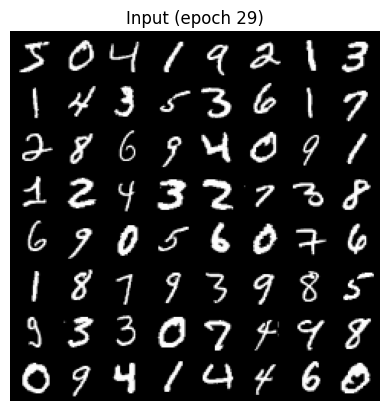

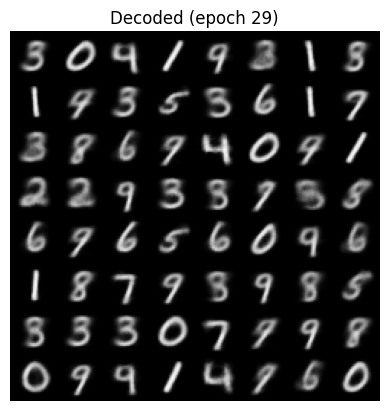

In [12]:
for epoch in range(30):
    for images, _ in train_loader:
        images = images.to(device)
        dist, decoded = model(images)
        loss = reconstruction_loss(decoded, images) + kl_divergence_loss(dist)
        opt.zero_grad()
        loss.backward()
        opt.step()
    clear_output()
    show_images(torch.stack([dataset[i][0] for i in range(64)]), title=f'Input (epoch {epoch})');
    show_images(model(torch.stack([dataset[i][0] for i in range(64)]).to(device))[1].cpu(), title=f'Decoded (epoch {epoch})');


In [13]:
model = model.cpu()

## Visualization

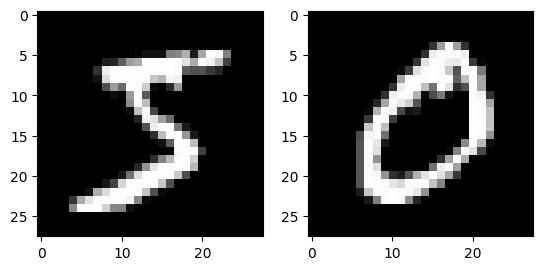

In [14]:
plt.subplot(1, 2, 1)
plt.imshow(dataset[0][0].permute(1, 2, 0), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(dataset[1][0].permute(1, 2, 0), cmap='gray');

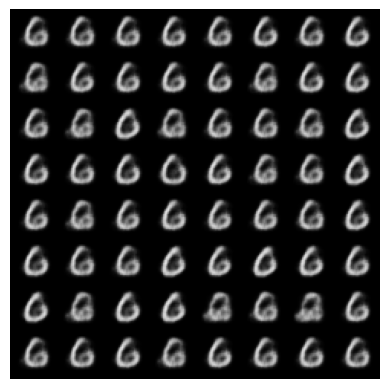

In [25]:
mu_1, sigma_1 = model.encoder(dataset[0][0].unsqueeze(0))
new_images = model.decoder(Normal(mu_1, sigma_1).sample_n(64).reshape(64, -1, 1, 1))
show_images(new_images);

torch.Size([15, 2])


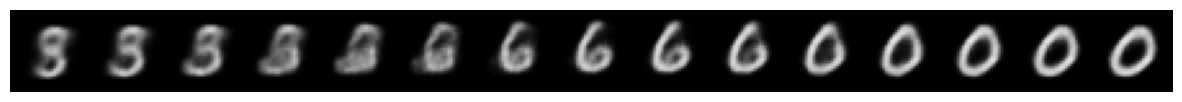

In [27]:
mu_2, sigma_2 = model.encoder(dataset[1][0].unsqueeze(0))
t = torch.linspace(0, 1, 15)[:, None]
interpolated_means = t@mu_2 + (1-t)@mu_1
print(interpolated_means.shape)

plt.figure(figsize=(15, 5))
show_images(model.decoder(interpolated_means[:, :, None, None]), nrow=15);

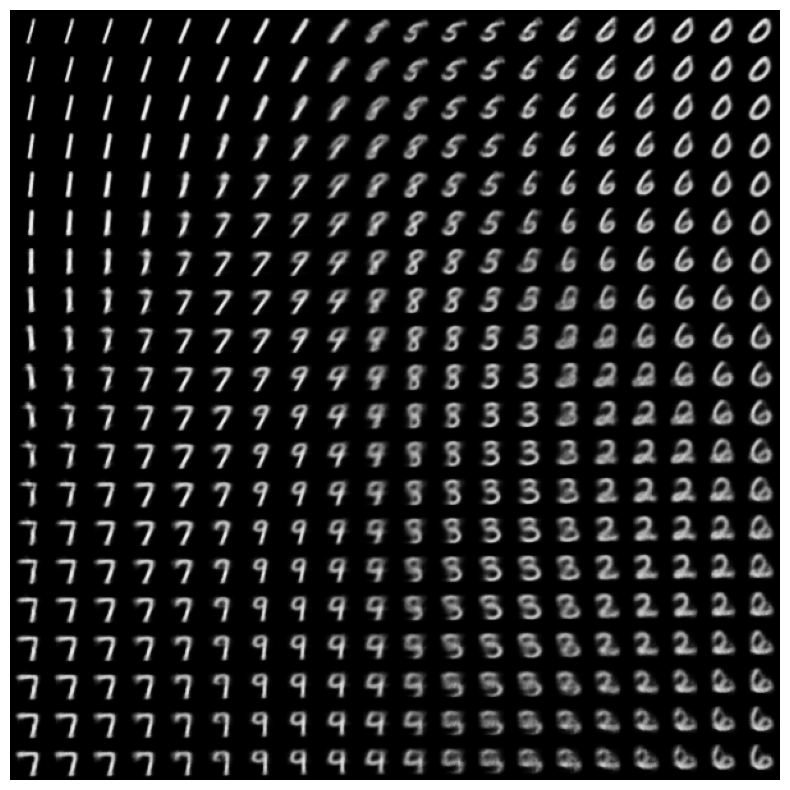

In [76]:
x_range = torch.linspace(-3, 3, 20)

y_range = torch.linspace(-3, 3, 20)
grid = torch.dstack(torch.meshgrid((x_range, y_range)))

plt.figure(figsize=(10, 10))
show_images(model.decoder(grid.reshape(-1, 2, 1, 1)), nrow=20);

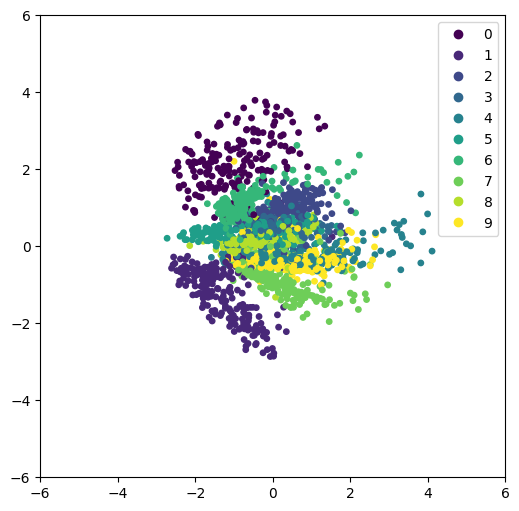

In [120]:
images, labels = next(iter(torch.utils.data.DataLoader(dataset, batch_size=2048)))
means = model.encoder(images)[0].detach()

plt.figure(figsize=(6, 6))

plt.ylim(-6, 6)
plt.xlim(-6, 6)

scatter = plt.scatter(means[:, 0], means[:, 1], c=labels, s=15)
plt.legend(*scatter.legend_elements());

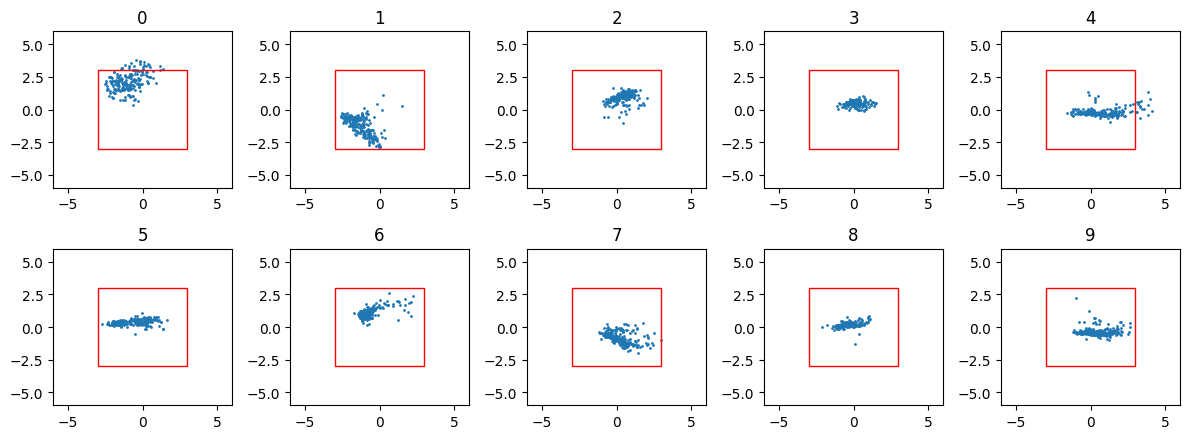

In [119]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(12, 4.5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    scatter = plt.scatter(means[labels == i][:, 0], means[labels == i][:, 1], s=1)
    plt.gca().add_patch(Rectangle((-3, -3), 6, 6,
                        edgecolor='red',
                        facecolor='none',
                        lw=1))
    plt.title(i)
plt.gcf().tight_layout()

In [36]:
mean_images = []
std_images = []
encoded_labels = []
for images, labels in train_loader:
    m, s = model.encoder(images)
    mean_images.append(m.detach())
    std_images.append(s.detach())
    encoded_labels.append(labels)
    
mean_images = torch.cat(mean_images, dim=0)
std_images = torch.cat(std_images, dim=0)
encoded_labels = torch.cat(encoded_labels)

mean_images.shape, std_images.shape, encoded_labels.shape

(torch.Size([60000, 2]), torch.Size([60000, 2]), torch.Size([60000]))

In [37]:
classes_mean, classes_std = torch.zeros((10, 2)), torch.zeros((10, 2))
for idx in range(10):
    classes_mean[idx] = torch.mean(mean_images[encoded_labels == idx], axis=0)
    classes_std[idx] = torch.mean(std_images[encoded_labels == idx], axis=0)
classes_mean, classes_std

(tensor([[ 0.8767,  1.4662],
         [-0.9051, -1.5365],
         [-0.1930,  1.0602],
         [ 0.4449,  0.2044],
         [ 1.1078, -0.5842],
         [ 0.2970, -0.0894],
         [-1.4179,  0.2391],
         [ 1.5040, -1.3044],
         [ 0.3703, -0.2523],
         [ 1.1136, -0.6209]]),
 tensor([[0.0578, 0.0715],
         [0.0612, 0.0826],
         [0.0599, 0.0898],
         [0.0554, 0.0441],
         [0.0771, 0.0500],
         [0.0578, 0.0488],
         [0.1056, 0.0531],
         [0.0705, 0.0807],
         [0.0498, 0.0520],
         [0.0690, 0.0544]]))

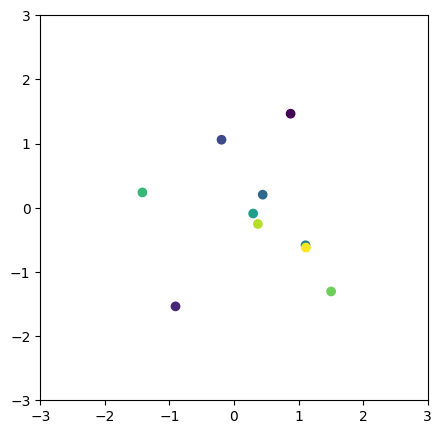

In [38]:
plt.figure(figsize=(5, 5))
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.scatter(classes_mean[:, 0], classes_mean[:, 1], c=range(10));
plt.show()

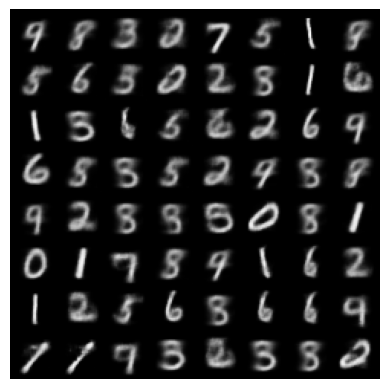

In [52]:
show_images(model.decoder(torch.normal(0, 1, (64, 2, 1, 1))));

## Higher Latent Space Dimension

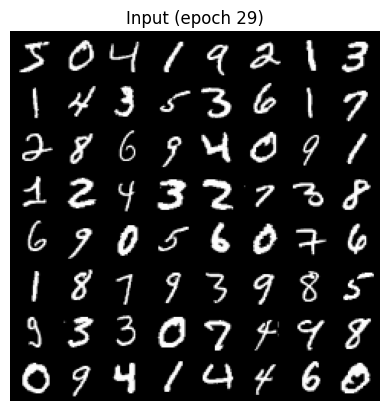

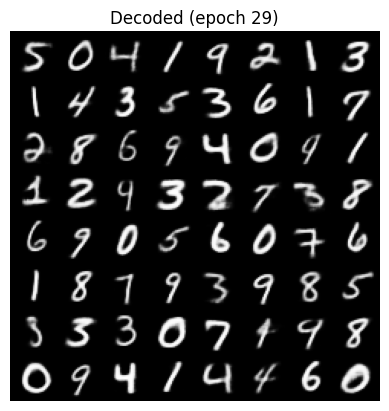

In [64]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
model = VariationAutoEncoder(img_channels=1, hidden_dim=20, z_dim=10).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(30):
    for images, _ in train_loader:
        images = images.to(device)
        dist, decoded = model(images)
        loss = reconstruction_loss(decoded, images) + kl_divergence_loss(dist)
        opt.zero_grad()
        loss.backward()
        opt.step()
    clear_output()
    show_images(torch.stack([dataset[i][0] for i in range(64)]), title=f'Input (epoch {epoch})');
    show_images(model(torch.stack([dataset[i][0] for i in range(64)]).to(device))[1].cpu(), title=f'Decoded (epoch {epoch})');

In [65]:
encoded_images = []
encoded_labels = []
for images, labels in train_loader:
    encoded_images.append(model.encoder(images.to(device))[0].detach().cpu())
    encoded_labels.append(labels)
    
encoded_images = torch.cat(encoded_images, 0)
encoded_labels = torch.cat(encoded_labels)

encoded_images.shape, encoded_labels.shape

(torch.Size([60000, 10]), torch.Size([60000]))

In [66]:
cov = np.cov(encoded_images.T.numpy())
eig_values, eig_vectors = np.linalg.eig(cov)

v1, v2 = eig_vectors[np.argsort(eig_values)[::-1][:2]]

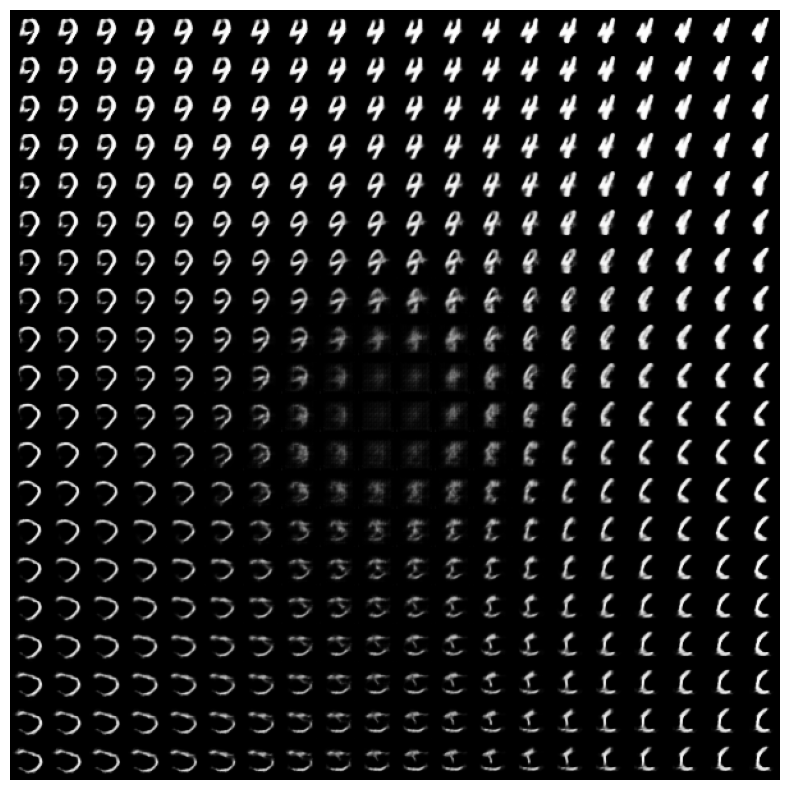

In [67]:
x_range = torch.linspace(-5, 5, 20)
y_range = torch.linspace(-5, 5, 20)

grid = (x_range[:, None] @ v1[None, :]).repeat(20, 1, 1) + (y_range[:, None] @ v2[None, :]).repeat(20, 1, 1).permute(1, 0, 2)

plt.figure(figsize=(10, 10))
show_images(model.decoder(grid.reshape(-1, 10, 1, 1).to(device).type(torch.float)).cpu(), nrow=20);

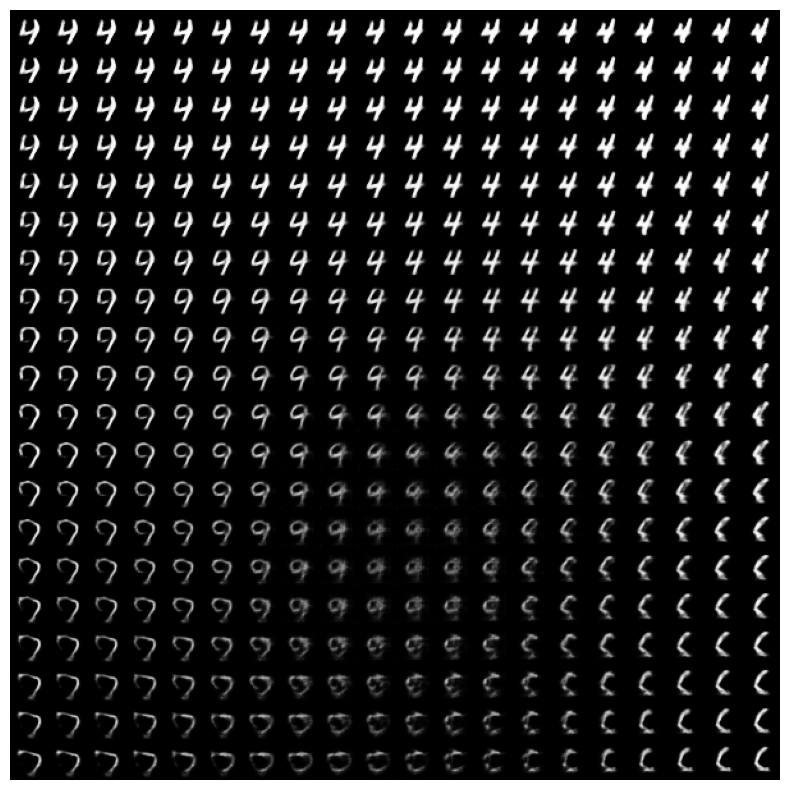

In [68]:
new_grid = grid + encoded_images[encoded_labels == 4].mean(dim=0)

plt.figure(figsize=(10, 10))
show_images(model.decoder(new_grid.reshape(-1, 10, 1, 1).to(device).type(torch.float)).cpu(), nrow=20);

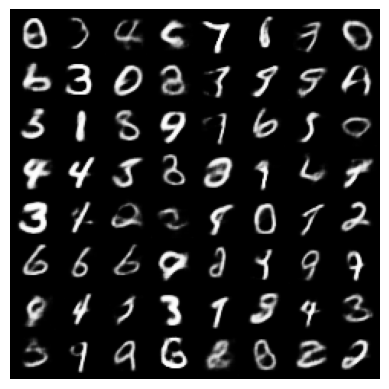

In [70]:
show_images(model.decoder(torch.normal(0, 1, (64, 10, 1, 1)).to(device)).cpu());